In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import joblib

%matplotlib inline
sns.set_style('whitegrid')

df = pd.read_csv('data/bank-additional-full.csv')


In [ ]:
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nTarget distribution:\n", df['y'].value_counts(normalize=True).map("{:.2%}".format))
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
numeric_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]
df[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


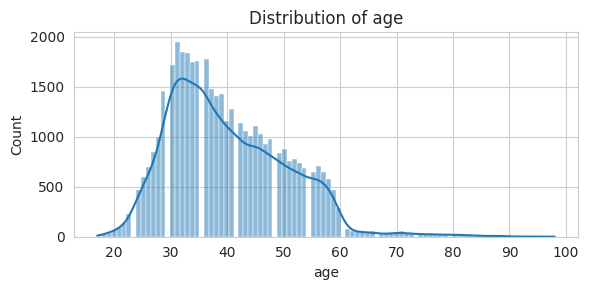

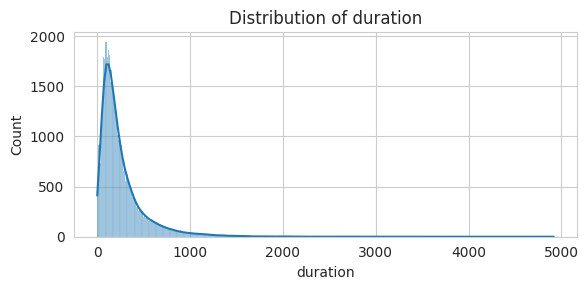

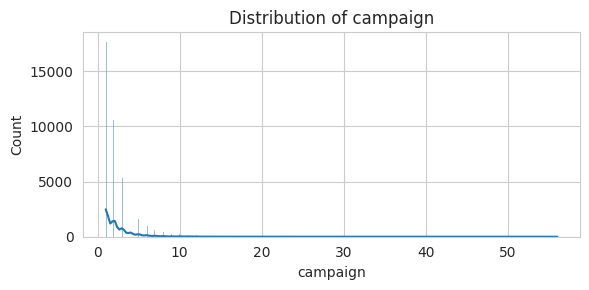

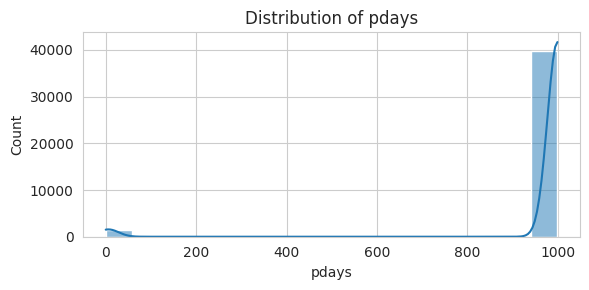

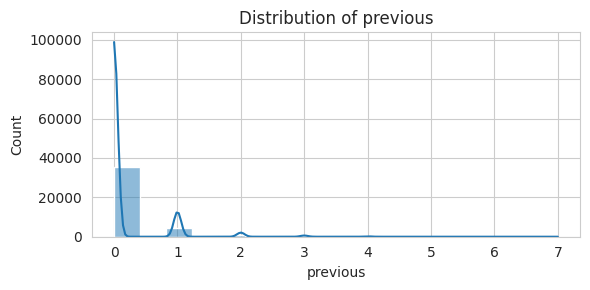

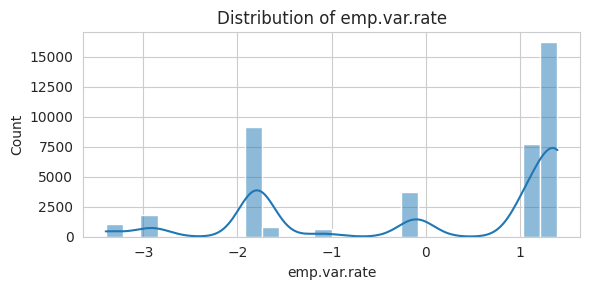

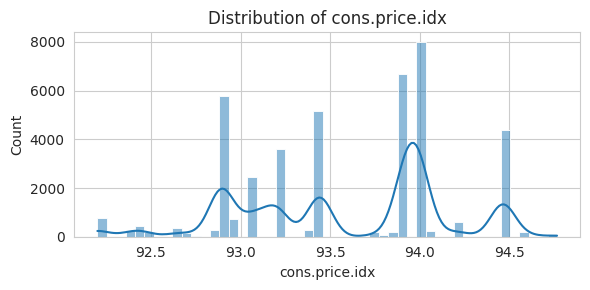

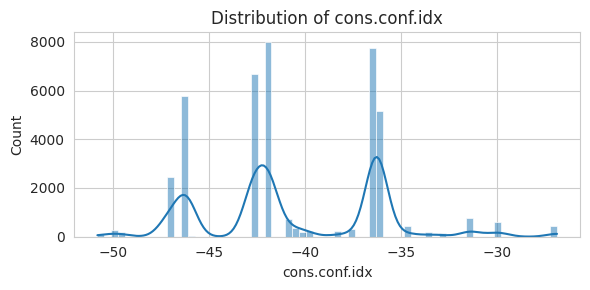

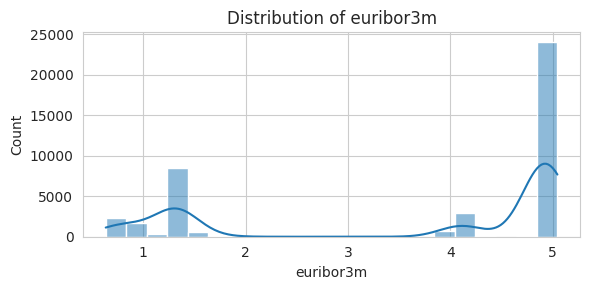

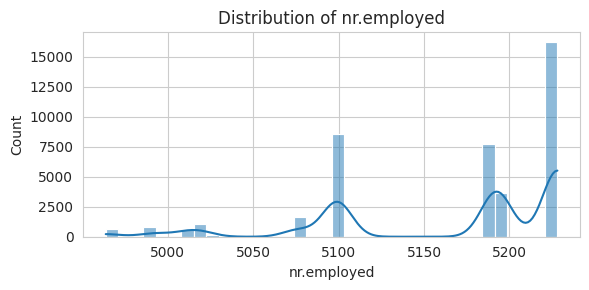

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


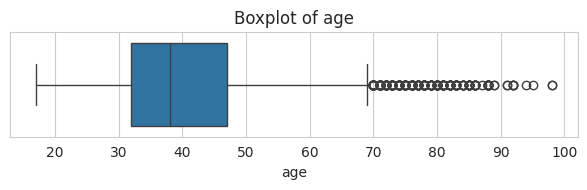

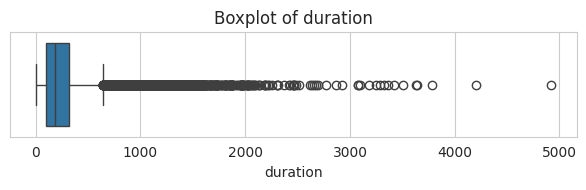

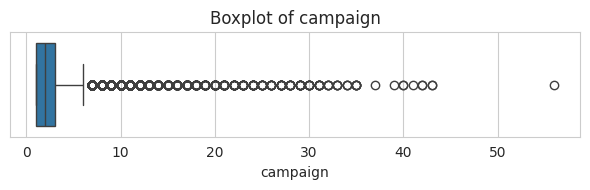

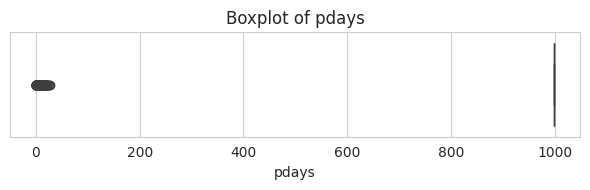

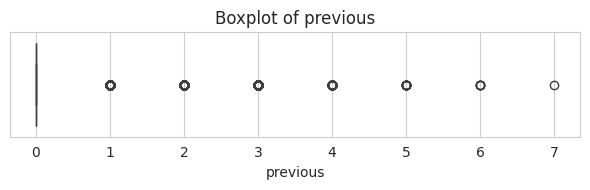

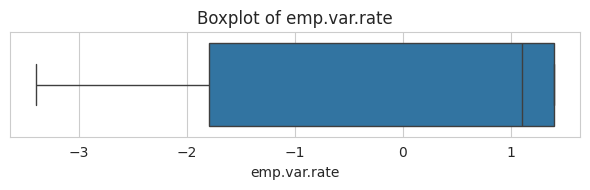

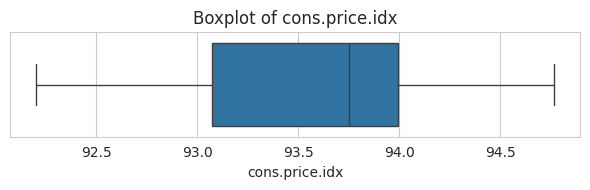

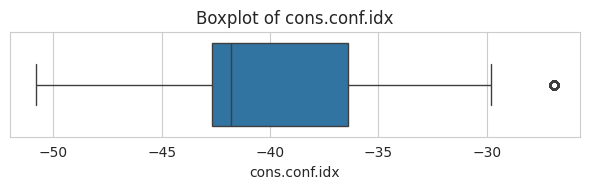

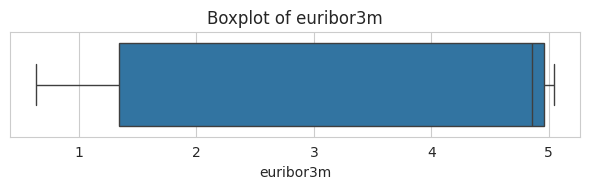

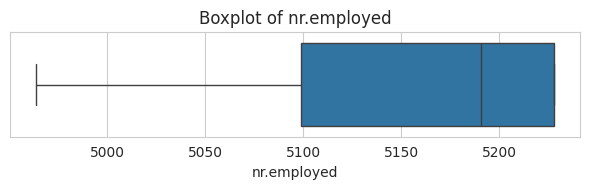

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


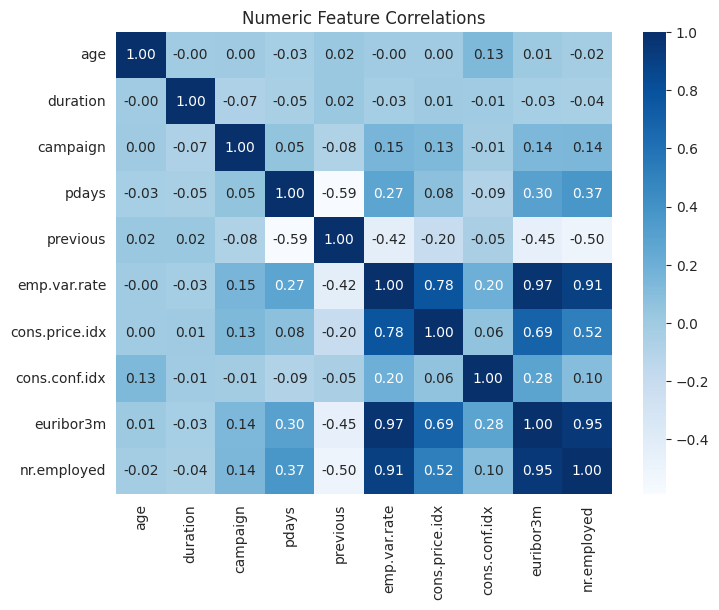

In [ ]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues')
plt.title('Numeric Feature Correlations')
plt.show()


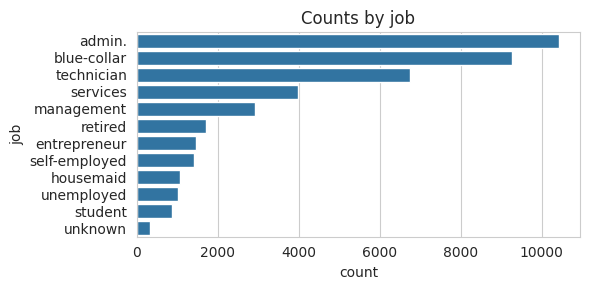

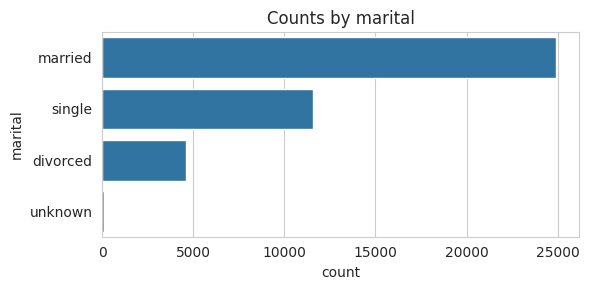

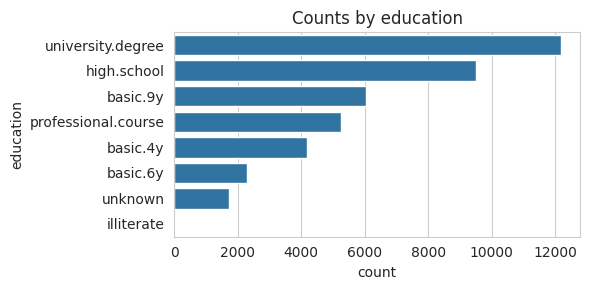

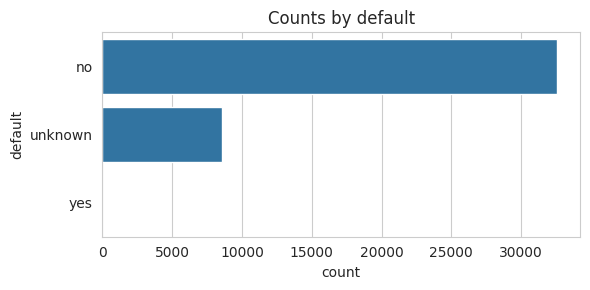

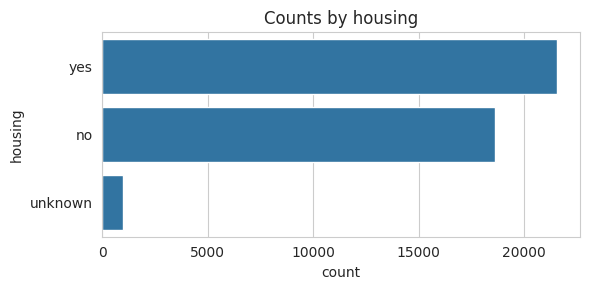

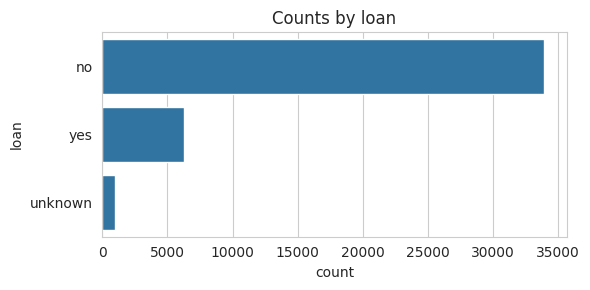

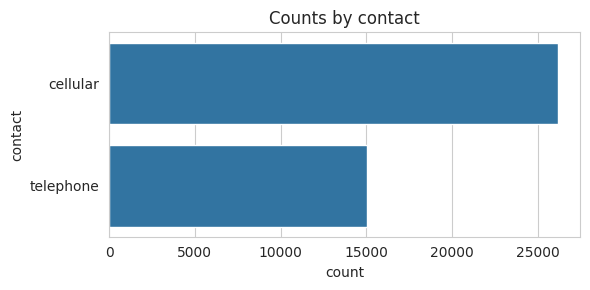

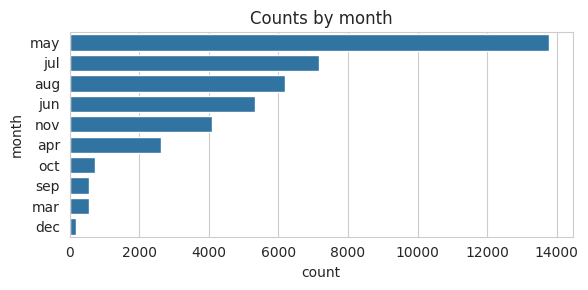

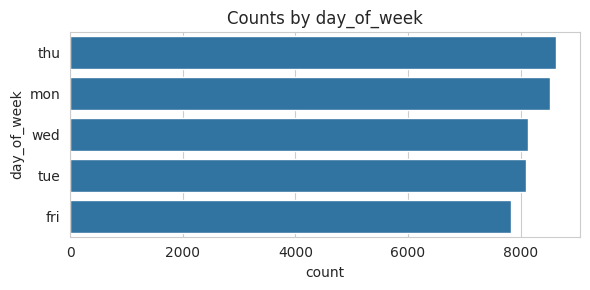

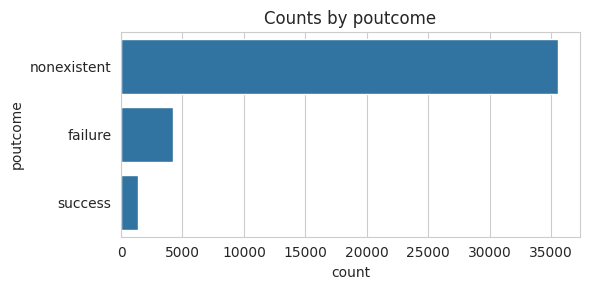

In [ ]:
cat_cols = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'month',
    'day_of_week', 'poutcome'
]
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Counts by {col}')
    plt.tight_layout()
    plt.show()


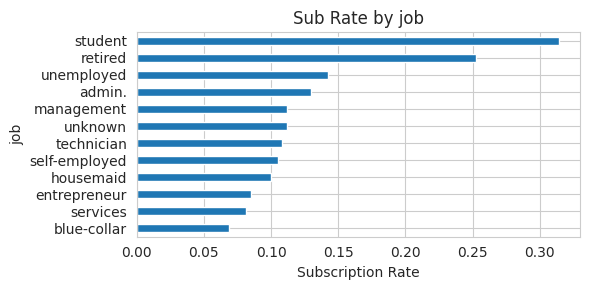

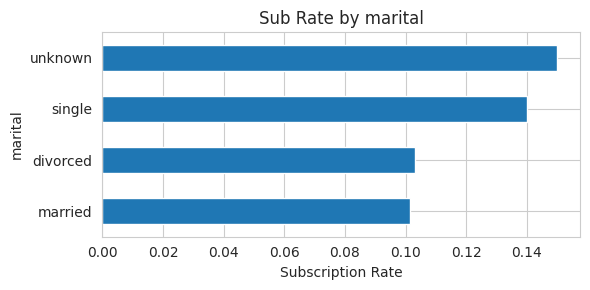

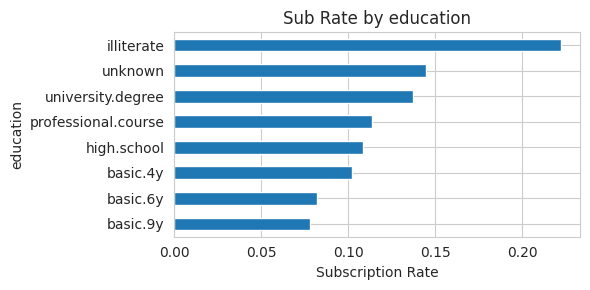

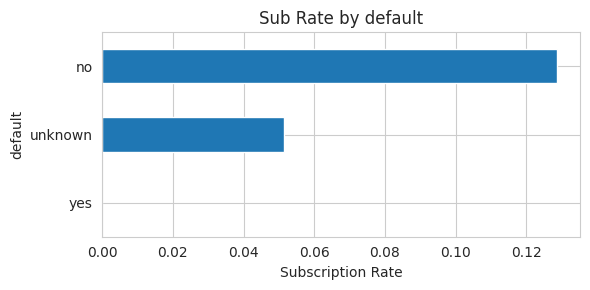

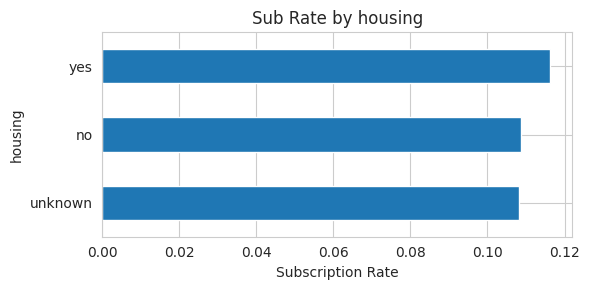

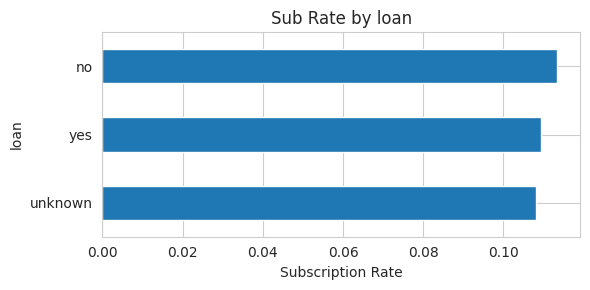

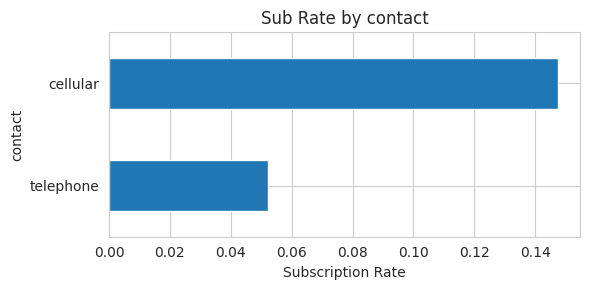

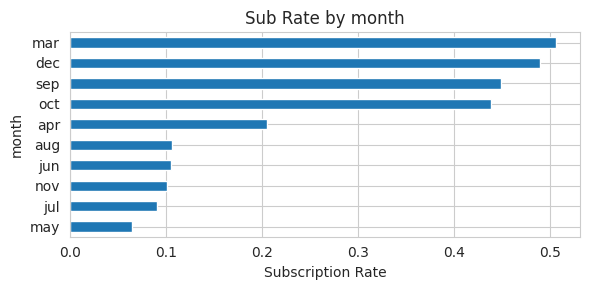

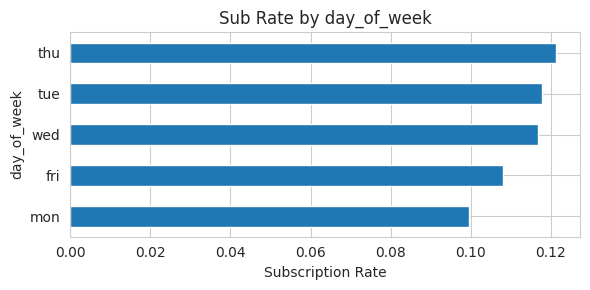

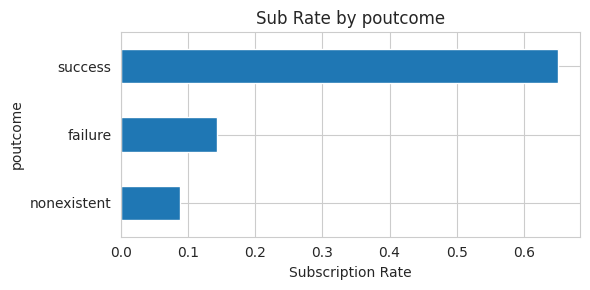

In [ ]:
for col in cat_cols:
    rates = df.groupby(col)['y']\
              .apply(lambda s: (s=='yes').mean())\
              .sort_values()
    plt.figure(figsize=(6,3))
    rates.plot.barh()
    plt.xlabel('Subscription Rate')
    plt.title(f'Sub Rate by {col}')
    plt.tight_layout()
    plt.show()


In [ ]:
df_enc = pd.get_dummies(df.drop('y', axis=1), drop_first=True)
y = (df['y']=='yes').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df_enc, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler().fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])


In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE: ", pd.Series(y_res).value_counts().to_dict())


Before SMOTE: {0: 29238, 1: 3712}
After SMOTE:  {0: 29238, 1: 29238}


In [ ]:
lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
lr.fit(X_res, y_res)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7310
           1       0.49      0.79      0.61       928

    accuracy                           0.88      8238
   macro avg       0.73      0.84      0.77      8238
weighted avg       0.92      0.88      0.90      8238



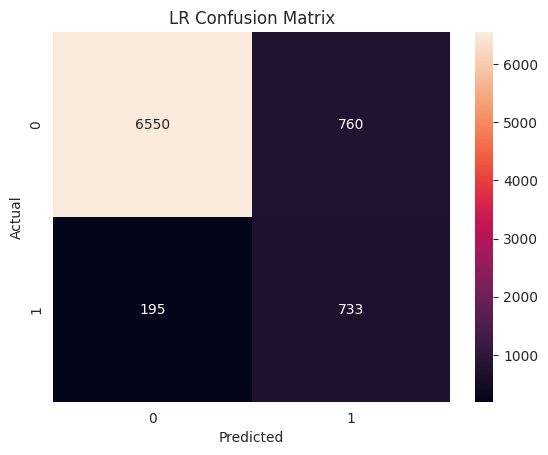

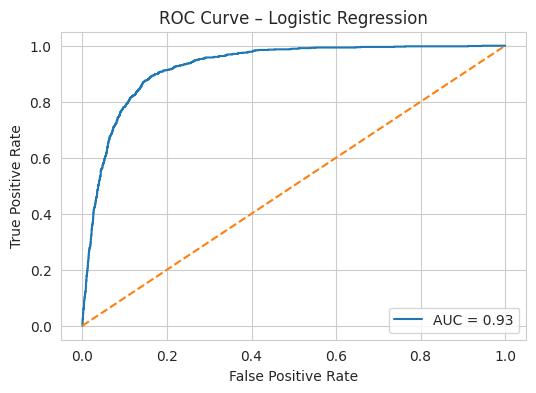

In [ ]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('LR Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob_lr = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve – Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
rf = RandomForestClassifier(
    n_estimators=100, class_weight='balanced',
    random_state=42, n_jobs=-1
)
rf.fit(X_res, y_res)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7310
           1       0.59      0.70      0.64       928

    accuracy                           0.91      8238
   macro avg       0.78      0.82      0.80      8238
weighted avg       0.92      0.91      0.91      8238



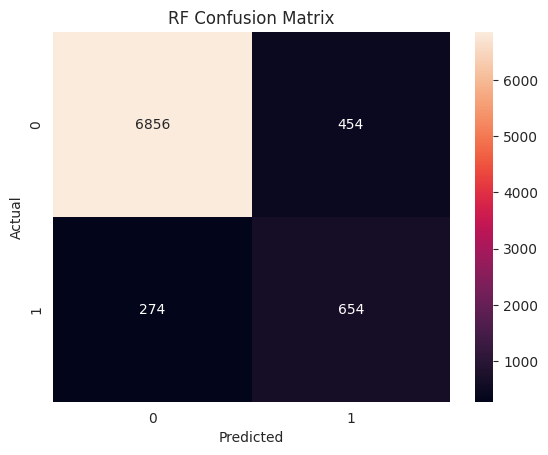

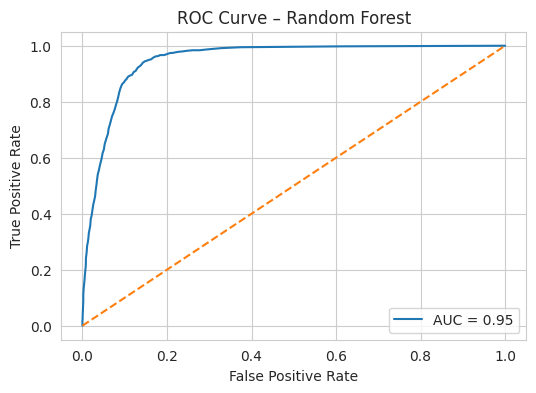

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('RF Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob_rf = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve – Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


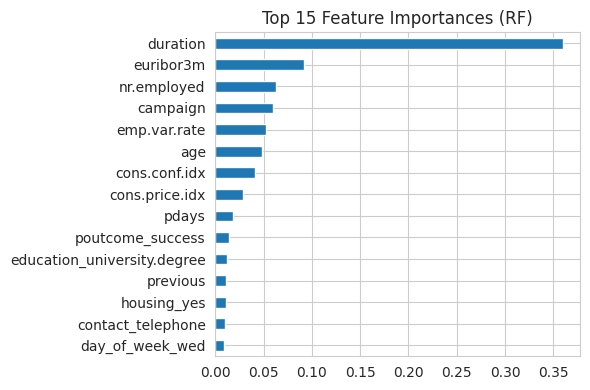

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X_res.columns)
top_imp = importances.sort_values(ascending=False).head(15)
plt.figure(figsize=(6,4))
top_imp.plot.barh()
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (RF)')
plt.tight_layout()
plt.show()


In [ ]:
best_model = rf
joblib.dump(best_model, 'term_deposit_model.pkl')
print("Saved model to term_deposit_model.pkl")


Saved model to term_deposit_model.pkl
